# C-N Benchmark Visualization

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from cn_benchmark_visualization import DomainWrapper, PlotExperiments
from summit.benchmarks import BaumgartnerCrossCouplingEmulator_Yield_Cost
from summit.strategies import Random
from summit.utils.multiobjective import hypervolume, pareto_efficient

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Pareto Front

In [ ]:
exp = BaumgartnerCrossCouplingEmulator_Yield_Cost()
exp.domain

In [33]:
def random_test(n_points, random_seed, hypervolume_ref=[0,1]):
    rand = Random(exp.domain, 
                  random_state=np.random.RandomState(random_seed))
    experiments = rand.suggest_experiments(n_points)
    exp.reset()
    exp.run_experiments(experiments)
    
    # Pareto front
    clear_output(wait=True)
    fig, ax = exp.pareto_plot()
    pareto_data = exp.pareto_data[['yld', 'cost']].to_numpy()
    pareto_data[:,0] *= -1.0 # change yld to minimization
    
    # Hypervolume
    hv = hypervolume(pareto_data, hypervolume_ref)
    
    #Formatting
    fig.suptitle(f'{n_points} points, hypervolume={hv}')
    plt.show()
    
    return hv

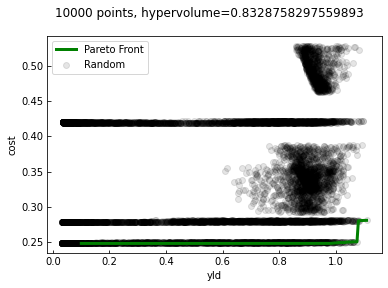

In [34]:
points = [100, 1000, 5000, int(1e4)]
hvs = []
for n_points in points:
    hvs.append(random_test(n_points, 100))

## CN Experiments

In [4]:
ids = [f'SUM-{i}' for i in range(1988, 2576)] + \
      [f'SUM-{i}' for i in range(3712, 3814)] + \
      [f'SUM-{i}' for i in range(4530, 4643)] + \
      [f'SUM-{i}' for i in range(4306, 4405)]
results = PlotExperiments("sustainable-processes/summit",
                          trajectory_length=50,
                          experiment_ids=ids,
                          tag=['cn_experiment_MO'],
                          state=['succeeded'])

In [8]:
print("Number of experiments for this benchmark:", len(results.runners)*50)

Number of experiments for this benchmark: 32000


Let's make an interactive plot of the hypervolume trajectories, for exploration sake. 

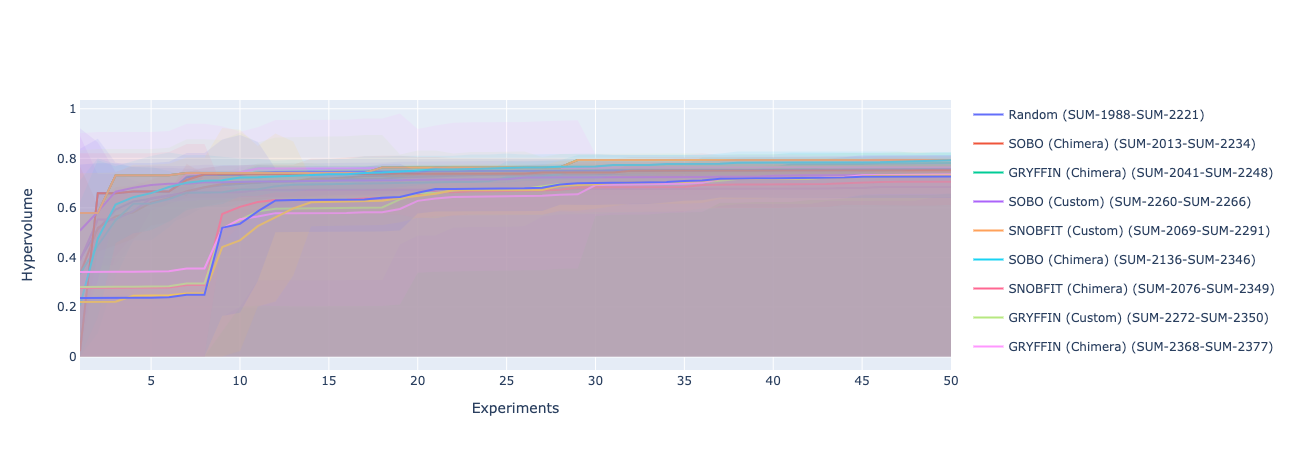

In [8]:
fig = results.plot_hv_trajectories(min_terminal_hv_avg=0.5, 
                                   include_experiment_ids=True,plot_type='plotly')

You can double click on an item in the legend to solo it. I'm going to increase the threshold for the publication figure, so I only include the top three strategies.

,Catalyst,Base,Base Equivalents,Temperature,$\Tau$,Yield,Cost
0,tBuXPhos,TMG,1.32,89.86,117.73,0.34,0.25
1,tBuXPhos,TMG,2.38,64.35,1594.63,0.52,0.25
11,tBuXPhos,DBU,2.03,71.12,1040.59,0.78,0.25
9,tBuBrettPhos,DBU,2.28,87.16,107.66,0.90,0.28
42,tBuBrettPhos,BTMG,2.50,99.32,1081.24,1.06,0.39
46,AlPhos,BTMG,2.25,99.89,1763.66,1.09,0.52


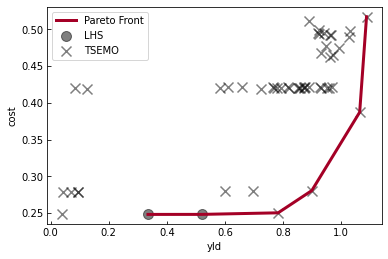

In [17]:
results.runners["SUM-4639"].experiment.pareto_plot()
data = results.runners["SUM-4639"].experiment.pareto_data
upper = lambda x: x.title().replace("_", " ")
data = data[["catalyst", "base", "base_equivalents", "temperature", "t_res", "yld", "cost"]]
data = data.rename(columns={"t_res": r"$\tau$", "yld": "Yield", "cost": "Cost"}).rename(columns=upper).round(2)
data

In [18]:
latex_str = data.to_latex(index=False, escape=False, bold_rows=False)
print(latex_str)

\begin{tabular}{llrrrrr}
\toprule
     Catalyst &  Base & Base Equivalents & Temperature &   $\Tau$ & Yield &  Cost \\
         Data &  Data &             Data &        Data &     Data &  Data &  Data \\
\midrule
     tBuXPhos &   TMG &             1.32 &       89.86 &   117.73 &  0.34 &  0.25 \\
     tBuXPhos &   TMG &             2.38 &       64.35 &  1594.63 &  0.52 &  0.25 \\
     tBuXPhos &   DBU &             2.03 &       71.12 &  1040.59 &  0.78 &  0.25 \\
 tBuBrettPhos &   DBU &             2.28 &       87.16 &   107.66 &  0.90 &  0.28 \\
 tBuBrettPhos &  BTMG &             2.50 &       99.32 &  1081.24 &  1.06 &  0.39 \\
       AlPhos &  BTMG &             2.25 &       99.89 &  1763.66 &  1.09 &  0.52 \\
\bottomrule
\end{tabular}



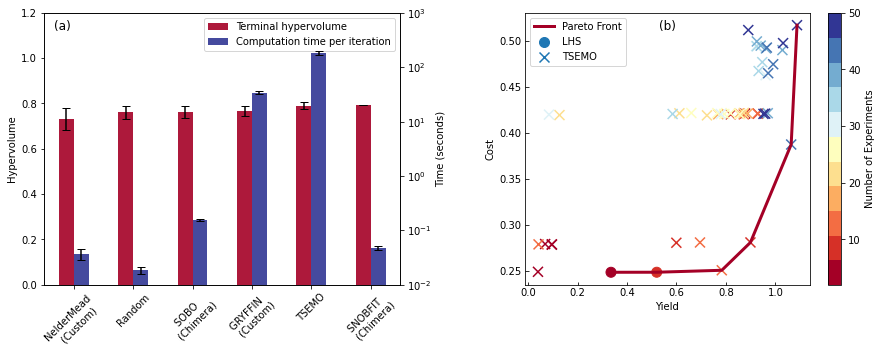

In [33]:
# Create figure
fig  = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=0.35,)

# Hypervolume, Time bar plot
ax = fig.add_subplot(1, 2, 1)
results.time_hv_bar_plot(ax)
ax.text(0.05,0.95, '(a)',
         horizontalalignment='center', 
         verticalalignment='center',
         transform = ax.transAxes,
         fontdict={'fontsize': 12})
ax.set_ylim(0,1.2)
ax.right_ax.set_ylim(1e-2, 1e3)

# Pareto plot
ax = fig.add_subplot(1, 2, 2)
r = results.runners["SUM-4639"]
ax, im = r.experiment.pareto_plot(colorbar=True, ax=ax)
fig.colorbar(im, ax=ax, label='Number of Experiments')
ax.set_xlabel("Yield")
ax.set_ylabel("Cost")
ax.text(0.5,0.95, '(b)',
             horizontalalignment='center', 
             verticalalignment='center',
             transform = ax.transAxes,
             fontdict={'fontsize': 12})

# Save figure
fig.savefig("figures/cn_hv_time_tradeoff.png", dpi=300, bbox_inches='tight')

# TODO: print out caption with transform settings.

In [26]:
df = results.df.copy()
df["computation_t"] = df["computation_t"]/results.trajectory_length
# Group repeats and take average
by = [
    "strategy_name",
    "transform_name",
    "yld_tolerance",
    "cost_tolerance",
    "use_descriptors",
    "batch_size",
]
# Group repeats and take average.
grouped_df = (
    df.groupby(by=by, dropna=False,)
    .head(results.num_repeats)
    .groupby(by=by, dropna=False)
)
stds = grouped_df.std().round(2)
counts = grouped_df.count()['experiment_id']
grouped_df = grouped_df.mean().round(2)
for col in ["terminal_hypervolume", 'computation_t']:
    grouped_df[col] = [f"{m}$\pm${s}"
                       for m, s in zip(grouped_df[col].values,
                                       stds[col].values)
                     ]
grouped_df['Repeats'] = counts
grouped_df

grouped_df.rename(columns={"terminal_hypervolume": "Terminal hypervolume",
                           "computation_t": "Time per iter. (s)"},
                  inplace=True)
grouped_df.index.rename(["Strategy", "Transform","Yield tolerance",
                         "Cost tolerance", "use descriptors", "batch_size"],
                        inplace=True)
grouped_df.index = grouped_df.index.droplevel(["batch_size", "use descriptors"])
grouped_df = grouped_df.fillna('-').round(0)
grouped_df

Terminal hypervolume  \
Strategy   Transform              Yield tolerance Cost tolerance                        
GRYFFIN    Chimera                0.5             0.5                    0.74$\pm$0.0   
                                                  1.0                   0.74$\pm$0.01   
                                  1.0             0.5                    0.74$\pm$0.0   
                                                  1.0                    0.74$\pm$0.0   
           MultitoSingleObjective NaN             NaN                   0.77$\pm$0.02   
NelderMead Chimera                0.5             0.5                   0.73$\pm$0.05   
                                                  1.0                   0.72$\pm$0.05   
                                  1.0             0.5                   0.72$\pm$0.05   
                                                  1.0                   0.72$\pm$0.05   
           MultitoSingleObjective NaN             NaN                   0.73$\pm$0.05   
Random     Transform              NaN             NaN                   0.76$\pm$0.03   
SNOBFIT    Chimera                0.5             0.5                    0.79$\pm$0.0   
                                                  1.0                   0.79$\pm$0.01   
                                  1.0             0.5                    0.79$\pm$0.0   
                                                  1.0                    0.79$\pm$0.0   
           MultitoSingleObjective NaN             NaN                    0.75$\pm$0.0   
SOBO       Chimera                0.5             0.5                   0.76$\pm$0.03   
                                                  1.0                   0.76$\pm$0.02   
                                  1.0             0.5                   0.76$\pm$0.03   
                                                  1.0                   0.76$\pm$0.03   
           MultitoSingleObjective NaN             NaN                   0.71$\pm$0.03   
TSEMO      Transform              NaN             NaN                   0.79$\pm$0.02   

                                                                 Time per iter. (s)  \
Strategy   Transform              Yield tolerance Cost tolerance                      
GRYFFIN    Chimera                0.5             0.5                15.13$\pm$0.52   
                                                  1.0                16.57$\pm$4.38   
                                  1.0             0.5                13.64$\pm$0.61   
                                                  1.0                14.35$\pm$1.25   
           MultitoSingleObjective NaN             NaN                34.21$\pm$1.95   
NelderMead Chimera                0.5             0.5                  0.03$\pm$0.0   
                                                  1.0                 0.04$\pm$0.01   
                                  1.0             0.5                 0.04$\pm$0.01   
                                                  1.0                 0.03$\pm$0.01   
           MultitoSingleObjective NaN             NaN                 0.04$\pm$0.01   
Random     Transform              NaN             NaN                  0.02$\pm$0.0   
SNOBFIT    Chimera                0.5             0.5                  0.05$\pm$0.0   
                                                  1.0                 0.06$\pm$0.03   
                                  1.0             0.5                  0.05$\pm$0.0   
                                                  1.0                  0.04$\pm$0.0   
           MultitoSingleObjective NaN             NaN                  0.06$\pm$0.0   
SOBO       Chimera                0.5             0.5                 0.14$\pm$0.01   
                                                  1.0                 0.15$\pm$0.01   
                                  1.0             0.5                 0.15$\pm$0.01   
                                                  1.0                 0.14$\pm$0.01   
           Mul

In [28]:
latex_str = grouped_df.to_latex(index=True, escape=False, bold_rows=False)
latex_str = latex_str.replace("MultitoSingleObjective", "Custom")
latex_str = latex_str.replace('NaN', '-')
print(latex_str)

\begin{tabular}{llllllr}
\toprule
      &           &     &     & Terminal hypervolume & Time per iter. (s) &  Repeats \\
Strategy & Transform & Yield tolerance & Cost tolerance &                      &                    &          \\
\midrule
GRYFFIN & Chimera & 0.5 & 0.5 &         0.74$\pm$0.0 &     15.13$\pm$0.52 &       20 \\
      &           &     & 1.0 &        0.74$\pm$0.01 &     16.57$\pm$4.38 &       20 \\
      &           & 1.0 & 0.5 &         0.74$\pm$0.0 &     13.64$\pm$0.61 &       20 \\
      &           &     & 1.0 &         0.74$\pm$0.0 &     14.35$\pm$1.25 &       20 \\
      & Custom & - & - &        0.77$\pm$0.02 &     34.21$\pm$1.95 &       20 \\
NelderMead & Chimera & 0.5 & 0.5 &        0.73$\pm$0.05 &       0.03$\pm$0.0 &       20 \\
      &           &     & 1.0 &        0.72$\pm$0.05 &      0.04$\pm$0.01 &       20 \\
      &           & 1.0 & 0.5 &        0.72$\pm$0.05 &      0.04$\pm$0.01 &       20 \\
      &           &     & 1.0 &        0.72$\pm$0.05 & 

I made the above parallel plot to show how the decision variables correspond with the objectives. However, I don't think it's clean enough for a publication.

Below, are the pareto plots for the run from each combination of strategy and transform that had the highest terminal hypervolume.

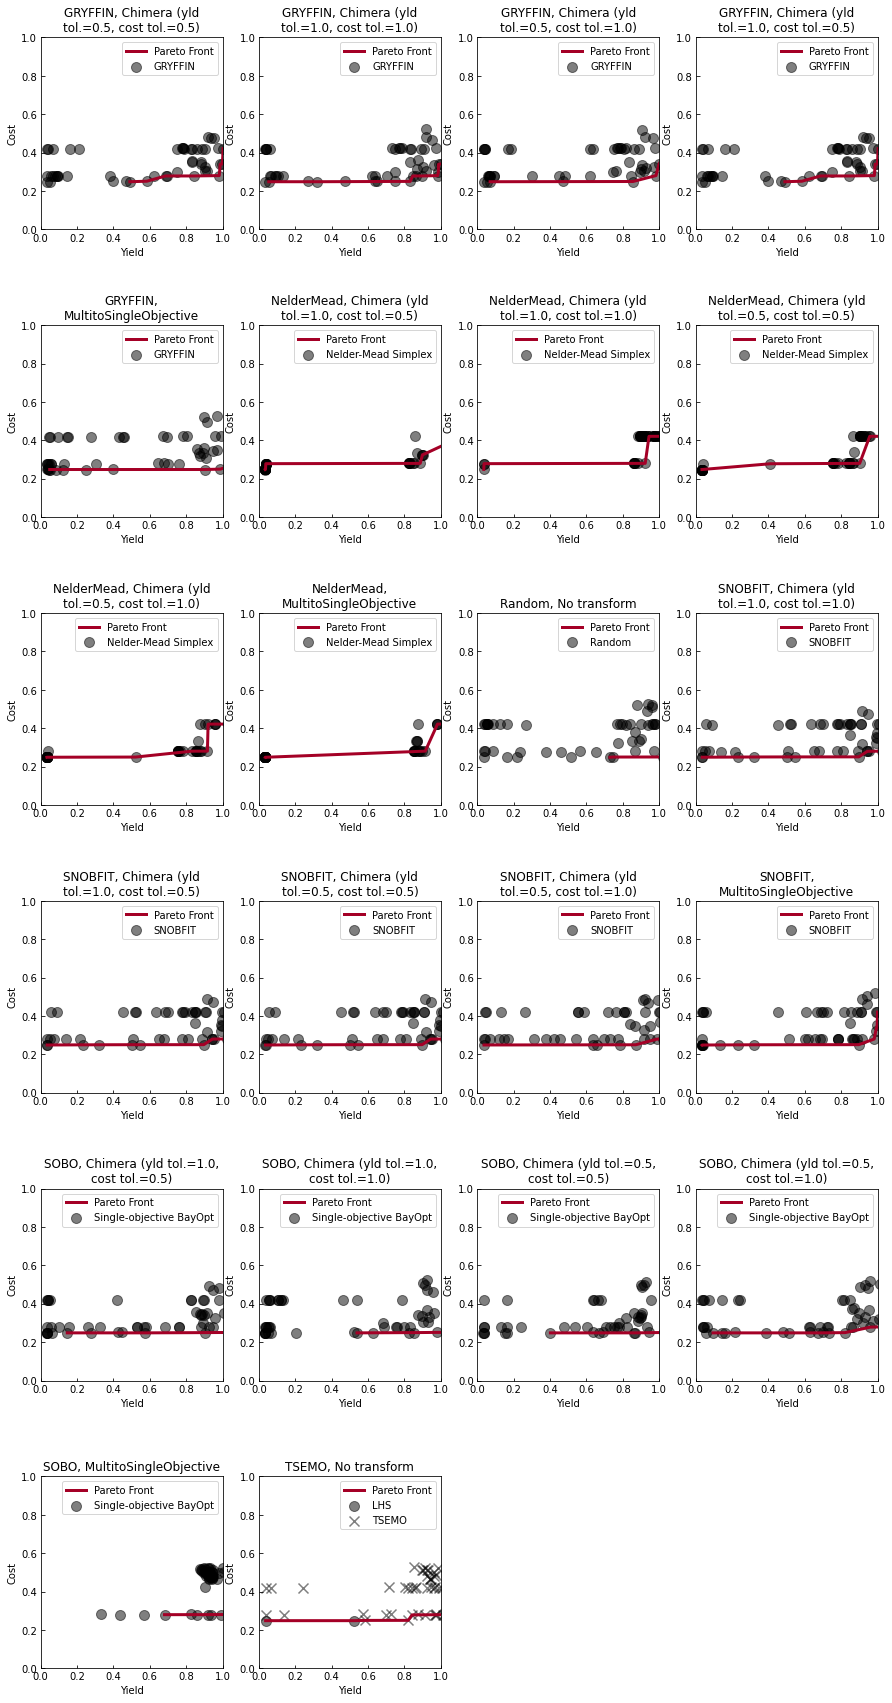

In [24]:
fig = results.best_pareto_grid(ncols=4, figsize=(15, 30))
fig.savefig('figures/cn_pareto_fronts.png', dpi=300, bbox_inches='tight')